---
title: One-Dimensional Finite Element Simulations

date: 2019-09-01

# Put any other Academic metadata here...
---

This notebook is based on an example from Chapter 2 of [An Introduction to Computational Stochastic PDEs](https://www.cambridge.org/gb/academic/subjects/mathematics/differential-and-integral-equations-dynamical-systems-and-co/introduction-computational-stochastic-pdes?format=PB&isbn=9780521728522).

The matrices assembled have few non-zero entries, so rather than store all entries in the matrix, only the non-zero values and there locations are stored. For this [compressed sparse column matrices](https://scipy-lectures.org/advanced/scipy_sparse/csc_matrix.html) are used, but this is an implementational detail.

First import the necessary libraries

In [1]:
import numpy as np
import scipy
from scipy import sparse
from scipy.sparse import linalg
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

Now define the function which assembles and solves the boundary value problem:

\begin{align}
-\dfrac{d}{dx} \left( \alpha(x) \dfrac{d u(x)}{dx} \right) + \gamma(x) u(x) = f(x) \quad a < x < b
\end{align}
with
\begin{equation}
u(a) = 0 \quad \mbox{and} \quad u(b) = 0.
\end{equation}

Note that the boundary value problem has a solution on (0,1) when $\alpha$, $\gamma$ and $f$ are constant, given by

\begin{equation}
u(x) = \dfrac{f}{\alpha} \left( 1 - \dfrac{ e^{\sqrt{s}x} + e^{\sqrt{s}(1-x)} }{ 1 + e^{\sqrt{s}} } \right) \quad \mbox{where} \quad s =\gamma / \alpha.
\end{equation}

Now define two functions to solve the problem numerically
* `get_elt_arrays` : which maps the basis functions
* `one_dimensional_linear_FEM` : which assembles and solves the finite element solution for the boundary value problem.

In [2]:
def one_dimensional_linear_FEM(N, alpha, gamma, f):
    """
    Solves the boundary value problem, returns the solution and the assembled matrices. 
    """

    # step size
    h = 1.0 / N
    
    # nodal points
    xx = np.linspace(0.0, 1.0, N+1)    
    
    # size of system
    nvtx = N + 1    
    
    # number of elements
    J = N- 1 
    
    # allocate matrix
    elt2vert = np.vstack((np.arange(0, J + 1, dtype='int'),
                          np.arange(1, J + 2, dtype='int')))
    
    # allocate space global matrices
    K = sparse.csc_matrix((nvtx, nvtx))   
    M = sparse.csc_matrix((nvtx, nvtx))
    
    # allocate right hand side of linear system
    b = np.zeros(nvtx)
    
    # compute element matrices 
    Kks, Mks, bks = get_elt_arrays(h, alpha, gamma, f, N)
    
    # Assemble element arrays into global arrays
    K = sum(sparse.csc_matrix((Kks[:, row_no, col_no], (elt2vert[row_no,:], elt2vert[col_no,:])), (nvtx,nvtx))
              for row_no in range(2)  for col_no in range(2))
    
    M = sum(sparse.csc_matrix((Mks[:, row_no, col_no], (elt2vert[row_no,:], elt2vert[col_no,:])), (nvtx,nvtx))
              for row_no in range(2)  for col_no in range(2))
    
    for row_no in range(2):
        nrow   = elt2vert[row_no,:]
        b[nrow] = b[nrow] + bks[:, row_no]
    
    # set lefthand side of the linear system
    A = K + M
    
    # impose homogeneous boundary condition
    A = A[1:-1, 1:-1] 
    K = K[1:-1, 1:-1] 
    M = M[1:-1, 1:-1]
    b = b[1:-1]
    
    # solve linear system for interior degrees of freedom
    u_int = sparse.linalg.spsolve(A,b)
    
    # append boundary data to interior solution 
    uh = np.hstack([0.0, u_int, 0.0])
    
    # return solution and the components of the linear system
    return uh, A, b, K, M

In [3]:
def get_elt_arrays(h, alpha, gamma, f, N):
    """
    Assemble stiffness and mass matrices and right handside vector.
    """

    Kks = np.zeros((N, 2, 2));    
    Kks[:,0,0] = alpha /h 
    Kks[:,0,1] = -alpha / h 
    Kks[:,1,0] = -alpha / h 
    Kks[:,1,1] = alpha / h
    
    Mks = np.zeros_like(Kks)
    Mks[:,0,0] = gamma * h / 3.0 
    Mks[:,0,1] = gamma * h / 6.0 
    Mks[:,1,0] = gamma * h / 6.0 
    Mks[:,1,1] = gamma * h / 3.0
    
    bks = np.zeros((N, 2))
    bks[:,0] = f * (h / 2.0) 
    bks[:,1] = f * (h / 2.0)
    
    return Kks, Mks, bks

Now create a function `eval_sol` which evaluates the exact solution for constant $\alpha$, $\gamma$ and $f$ on $(0,1)$

In [4]:
def eval_sol(f, alpha, gamma, x):
    """
    Evaluate exact solution 
    """   
    s = gamma / alpha
    out = (f / gamma) * (1.0 - (np.exp(np.sqrt(s) * x) + np.exp(np.sqrt(s) * (1.0-x))) / (1.0 + np.exp(np.sqrt(s))) )
    return out

Evaluate the exact solution for $\alpha=1$, $\gamma=10$ and $f=1$

In [5]:
x0 = 0.0
x1 = 1.0
L = 100
x = np.linspace(x0, x1, L)
f = 1.0 
alpha = 1.0 
gamma = 10.0
u = eval_sol(f, alpha, gamma, x)

For a number of different step sizes compute the finite element approximation

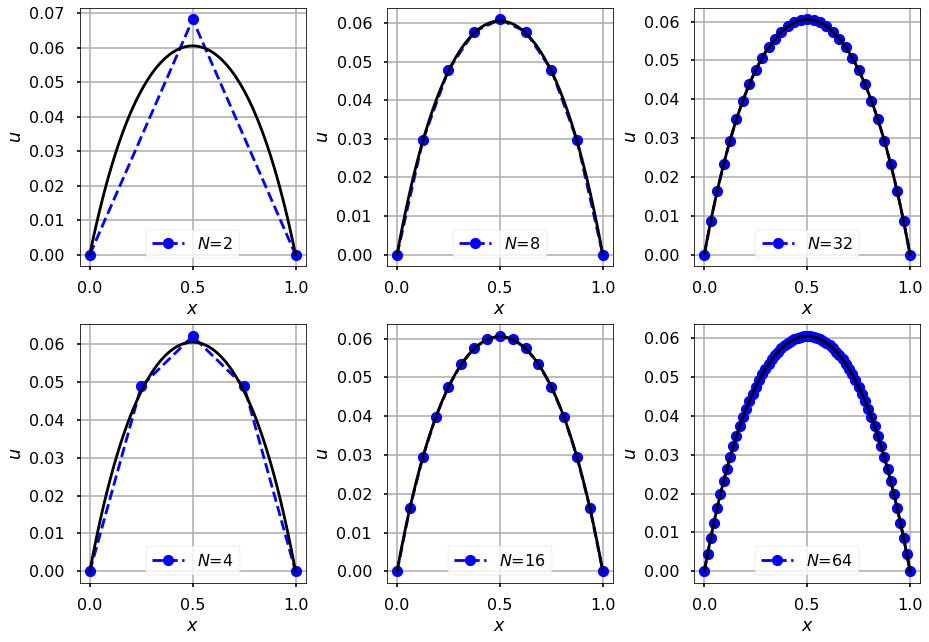

In [6]:
npowers = 6
fig, axes = plt.subplots(2, int(npowers/2), constrained_layout=True)
for i in range(1, 1+npowers):
    plt.subplot(2, int(npowers/2), i)
    N = int( np.power(2, i) )
    xh = np.linspace(x0, x1, N+1)
    uh, A, b, K, M = one_dimensional_linear_FEM(N, alpha, gamma, f)
    axes[(i-1)%2, (i-1)//2].plot(xh, uh, '--ob', label="$N$={}".format(N))
    axes[(i-1)%2, (i-1)//2].set_xlabel(r'$x$')
    axes[(i-1)%2, (i-1)//2].set_ylabel(r'$u$')
    axes[(i-1)%2, (i-1)//2].plot(x, u, '-k')
    axes[(i-1)%2, (i-1)//2].grid(True)
    axes[(i-1)%2, (i-1)//2].legend(loc='lower center')


## Error Analysis

Compute the error via a norm defined using the bilinear form

\begin{equation}
a(u,v) = \int_a^b \alpha u^{\prime}(x) v^{\prime}(x) + \gamma u(x) v(x) \mathrm{d}x
\end{equation}

that is 

\begin{equation}
\left\Vert u \right\Vert_V = \sqrt{a(u,u)}
\end{equation}

so that the error is given by

\begin{equation}
\left\Vert u - u_h \right\Vert_V^2.
\end{equation}

When $\alpha=1$, $\gamma=0$ and $f=1$, the exact solution is given by $u=\frac{1}{2}x(1-x)$. Thus $u^{\prime}= \frac{1}{2}-x$. Evaluating the integral for the error then leads to

\begin{equation}
\left\Vert u - u_h \right\Vert_V^2 = \sum\limits_{i=1}^{N} \int_{x_{i-1}}^{x_{i}} \left( \dfrac{1}{2} -x - u_h^{\prime} \right)^2 \mathrm{d}x
\end{equation}

Now expanding $u_h$ in terms of the basis functions

\begin{equation}
u_h = u^k_1 \varphi_1^k + u^k_2 \varphi_2^k
\end{equation}

So that $u_h^{\prime} = \dfrac{u_1^k - u_2^k}{h}$.

The square of the error in the $i^{\mathrm{th}}$-element $E_i^2$ can be evaluated using Simpson's rule, i.e.

\begin{equation}
\int_{x_{i-1}}^{x_i} g(x) \, \mathrm{d}x \approx \dfrac{h}{6}\left( g\left( x_{i-1} \right) + 4 g\left( x_{i-1/2} \right) + g\left( x_{i} \right) \right).
\end{equation}

In [7]:
def FEM_error(N, uh, x0, x1):
    """
    Compute error with repect to the norm from the bilinear form
    """
    
    h = 1.0 / N    
    x = np.linspace(x0, x1, N+1)
    u1s = uh[:-1] 
    u2s = uh[1:]
    
    # quadrature weights and points according to Simpson's rule
    weights = h * np.array([1.0/6.0, 2.0/3.0, 1.0/6.0])
    
    
    x_quad = np.vstack([x[:-1],
                        x[:-1] + h / 2.0,
                        x[1:]])
    
    Err2 = sum( weights[i] * element_error_squared(x_quad[i,:], u1s / h, u2s / h) for i in range(3))
    
    return np.sqrt( sum(Err2) ) 

def element_error_squared(x, u1, u2):
    """
    Evaluation of the error using the derivative of the exact solution given values of alpha, gamma and f.
    """
    Ek2 = (0.5 - x + u1 - u2) ** 2
    return Ek2

Now evaluate the error for different steps sizes:

In [8]:
m = np.array([4,8,16], dtype=int)
error = np.zeros((m.size,))
x0 = 0.0
x1 = 1.0
for j, k in enumerate(m):
    N = k
    f = 1.0 
    alpha = 1.0 
    gamma = np.zeros((k,))
    uh, A, b, K, M = one_dimensional_linear_FEM(N, alpha, gamma, f)    
    error[j] = FEM_error(N, uh, x0, x1)
results = np.vstack([m.T, error ])
import pandas as pd
df = pd.DataFrame(results.T, columns=["Order", "Error"])
df.Order = df.Order.astype(int)
display(df.style.hide_index().set_caption("Results for $\dfrac{1}{2}x(1-x)$"))

Order,Error
4,0.072169
8,0.036084
16,0.018042
